# Model Analysis Suite



In [2]:
# PSL imports,
import os

# Third-party imports,
import numpy as np
import scipy
import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import r2_score
import skimage

# Matplotlib imports,
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Notebook imports,
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import HBox, Dropdown, interact
import ipywidgets as widgets
from google.colab import drive

# Testing Dataset

## Load Data

In [3]:
# Mounting drive,
drive.mount("/content/drive", force_remount=True)

# Loading grids,
DMD_grid = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD_data.npy")
Ne_grid = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/targets(DMP-Ne).npy")
T_grid = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/targets(DMP-T).npy")
redshift_labels = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/predictions_z.npy")

# Loading model predictions,
T_pred = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/predictions(DMP-T).npy")
Ne_pred = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/predictions(DMP-Ne).npy")

Mounted at /content/drive


## Visualisations



Use this to visualise the model prediction for the jth test image.

In [4]:
# Specifiy jth sample,
j = 129
PIXEL_SCALE = 25/256 # Mpc/h
redshift = redshift_labels[j]

def compute_emissivity(n_e, T):
    return (1.42*1e-27)*(n_e**2)*(T**0.5)

def plot_field(field="Electron Number Density"):

    # Selecting grid data based on dropdown choice,
    if field == "Electron Number Density":
        field_data = Ne_grid[j]
        field_pred = Ne_pred[j]
        CMAP = "plasma"
    elif field == "Gas Temperature":
        field_data = T_grid[j]
        field_pred = T_pred[j]
        CMAP = "inferno"
    elif field == "Total Emissivity":
        field_data = compute_emissivity(Ne_grid[j], T_grid[j])
        field_pred = compute_emissivity(Ne_pred[j], T_pred[j])
        CMAP = "inferno"

    # Creating figure,
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting ground truth,
    img1 = axes[0].imshow(np.log10(field_data), cmap=CMAP)
    axes[0].text(20, 20, f"j={j}, z={redshift}", color="white", fontsize=12)
    axes[0].set_title("Ground Truth")
    axes[0].set_xlabel("Mpc/$h$")
    axes[0].set_ylabel("Mpc/$h$")

    # Plotting model prediction,
    img2 = axes[1].imshow(np.log10(field_pred), cmap=CMAP)
    axes[1].set_title("Prediction")
    axes[1].set_xlabel("Mpc/$h$")

    # Plotting LPE,
    img_LPE = np.log10(field_pred/field_data)
    img3 = axes[2].imshow(img_LPE, cmap="bwr", vmin=-1, vmax=1)
    axes[2].set_title("LPE")
    axes[2].set_xlabel("Mpc/$h$")
    cbar = fig.colorbar(img3, ax=axes[2], orientation="vertical", label="LPE")

    # Updating xticks and yticks,
    for ax in axes:

      xticks = ax.get_xticks()[1:-1]
      yticks = ax.get_yticks()[1:-1]

      # Converting into physical units,
      xtick_labels = [f"{x * PIXEL_SCALE:.0f}" for x in xticks]
      ytick_labels = [f"{y * PIXEL_SCALE:.0f}" for y in yticks]

      # Inverting y-axis ticks,
      ytick_labels = ytick_labels[::-1]

      # Setting ticks,
      ax.set_xticks(xticks)
      ax.set_xticklabels(xtick_labels)
      ax.set_yticks(yticks)
      ax.set_yticklabels(ytick_labels)

    # Displaying plot,
    plt.tight_layout()
    plt.show()

# Creating dropdown menu,
interact(plot_field, field=Dropdown(options=["Electron Number Density", "Gas Temperature", "Total Emissivity"], description="Field"));

interactive(children=(Dropdown(description='Field', options=('Electron Number Density', 'Gas Temperature', 'To…

The same visualisation, but for more samples simultaneously.

In [11]:
# Display j_list samples,
j_list = np.random.randint(low=0, high=511, size=9, dtype=int)
j_list = [14, 162, 324, 345, 280, 93, 324, 467, 293]

def plot_fields(field="Electron Number Density"):

    # Selecting grid data based on dropdown choice,
    if field == "Electron Number Density":
        field = Ne_grid
        field_pred = Ne_pred
        CMAP = "plasma"
    elif field == "Gas Temperature":
        field = T_grid
        field_pred = T_pred
        CMAP = "inferno"
    elif field == "Total Emissivity":
        field = compute_emissivity(Ne_grid, T_grid)
        field_pred = compute_emissivity(Ne_pred, T_pred)
        CMAP = "inferno"

    # Creating figure,
    fig, axes = plt.subplots(
        3, 6, figsize=(20, 10),
        gridspec_kw={"wspace": 0.05, "hspace": 0.1}
    )

    # Plotting loop,
    for idx, j in enumerate(j_list):

        # Determining rows and columns,
        row = idx // 3
        col = idx % 3

        # Extracting redshift,
        redshift = redshift_labels[j]

        # Plotting ground truth,
        ax_gt = axes[row, col]
        ax_gt.imshow(np.log10(field[j]), cmap=CMAP)
        ax_gt.text(10, 25, f"j={j}, z={redshift}", color="white", fontsize=12)
        ax_gt.set_xticks([])
        ax_gt.set_yticks([])
        for spine in ax_gt.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

        # Poltting model prediction,
        ax_pred = axes[row, col + 3]
        ax_pred.imshow(np.log10(field_pred[j]), cmap=CMAP)
        ax_pred.set_xticks([])
        ax_pred.set_yticks([])
        for spine in ax_pred.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

    # Display plot,
    plt.show()

# Creating dropdown menu,
interact(plot_fields, field=Dropdown(options=["Electron Number Density", "Gas Temperature", "Total Emissivity"], description="Field"));

interactive(children=(Dropdown(description='Field', options=('Electron Number Density', 'Gas Temperature', 'To…

## LPE Maps

In [17]:
# Toggle to specifiy j_list,
j_list = [14, 162, 324, 345, 280, 93, 324, 467, 293]

def plot_lpe(field="Electron Number Density"):

    # Selecting grid data based on dropdown choice,
    if field == "Electron Number Density":
        field_data = Ne_grid
        field_pred = Ne_pred
        CMAP = "plasma"
    elif field == "Gas Temperature":
        field_data = T_grid
        field_pred = T_pred
        CMAP = "inferno"
    elif field == "Total Emissivity":
        field_data = compute_emissivity(Ne_grid, T_grid)
        field_pred = compute_emissivity(Ne_pred, T_pred)
        CMAP = "inferno"

    # Creating figure,
    fig, axes = plt.subplots(
        3, 6, figsize=(20, 10),
        gridspec_kw={"wspace": 0.05, "hspace": 0.1}
    )

    img_for_cbar = None  # Will store the image object for colorbar

    # Plotting loop,
    for idx, j in enumerate(j_list):
        row = idx // 3
        col = idx % 3

        redshift = redshift_labels[j]

        # Left column: ground truth,
        ax_gt = axes[row, col]
        ax_gt.imshow(np.log10(field_pred[j]), cmap=CMAP)
        ax_gt.text(10, 25, f"j={j}, z={redshift}", color="white", fontsize=12)
        ax_gt.set_xticks([])
        ax_gt.set_yticks([])
        for spine in ax_gt.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

        # Right column: log prediction error,
        img_LPE = np.log10(field_pred[j] / field_data[j])
        ax_lpe = axes[row, col + 3]
        img = ax_lpe.imshow(img_LPE, cmap="bwr", vmin=-1, vmax=1)
        if img_for_cbar is None:
            img_for_cbar = img  # Save first image for colorbar
        ax_lpe.set_xticks([])
        ax_lpe.set_yticks([])
        for spine in ax_lpe.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

    # Add shared colorbar for the right column,
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    fig.colorbar(img_for_cbar, cax=cbar_ax, label="LPE")

    plt.show()

# Creating dropdown menu,
interact(plot_lpe, field=Dropdown(options=["Electron Number Density", "Gas Temperature", "Total Emissivity"], description="Field"))

interactive(children=(Dropdown(description='Field', options=('Electron Number Density', 'Gas Temperature', 'To…

<function __main__.plot_lpe(field='Electron Number Density')>

## Image Metrics

In [22]:
# Functions,
def compute_LPE(image, image_pred):
    """Computes the logarithmic prediction error (LPE)."""
    return np.mean(np.abs(np.log10(image/image_pred)))

def compute_KL(hist_gt, hist_pred, epsilon=1e-10):
    """Safely computes KL divergence between two histograms."""

    # Adding epsilson to avoid 0/0 divide,
    hist_gt = np.asarray(hist_gt, dtype=np.float64) + epsilon
    hist_pred = np.asarray(hist_pred, dtype=np.float64) + epsilon

    # Normalise to get valid PDFs,
    hist_gt /= np.sum(hist_gt)
    hist_pred /= np.sum(hist_pred)

    return scipy.stats.entropy(hist_gt, hist_pred)

def compute_peak(axis_obj):
  """Finds the location of the highest point of the KDE after it has been created by Seaborn."""

  # Accessing values,
  for line in axis_obj.lines:
    x_vals = line.get_xdata()
    y_vals = line.get_ydata()
    break

  # Finding KDE peak,
  peak_x = x_vals[np.argmax(y_vals)]

  return peak_x

# Parameters,
N_BINS = 50

def plot_metrics(field_name="Electron Number Density"):

    # Selecting grid data based on dropdown choice,
    if field_name == "Electron Number Density":
      field = Ne_grid
      field_pred = Ne_pred
      CMAP = "plasma"
    elif field_name == "Gas Temperature":
      field = T_grid
      field_pred = T_pred
      CMAP = "inferno"

    # Creating figures,
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Creating empty lists,
    SSIM_list = []
    LPE_list = []
    KL_list = []

    # Looping through all training samples,
    for image, image_pred in zip(field, field_pred):

      image_range = image_pred.max() - image_pred.min()

      # Computing metrics,
      image_SSIM = skimage.metrics.structural_similarity(image, image_pred, data_range=image_range)
      image_LPE = compute_LPE(image, image_pred)

      hist_gt, _ = np.histogram(np.log10(image).flatten(), bins=N_BINS, density=False)
      hist_pred, _ = np.histogram(np.log10(image_pred.flatten()), bins=N_BINS, density=False)
      image_KL = compute_KL(hist_gt, hist_pred)

      # Appending to lists,
      SSIM_list.append(image_SSIM)
      LPE_list.append(image_LPE)
      KL_list.append(image_KL)

    # Computing statistics,
    SSIM_mean = np.mean(SSIM_list)
    SSIM_std = np.std(SSIM_list)
    LPE_mean = np.mean(LPE_list)
    LPE_std = np.std(LPE_list)
    KL_mean = np.mean(KL_list)

    print(f"SSIM: {SSIM_mean} ± {SSIM_std}, MSE: {LPE_mean} ± {LPE_std}")

    # Plotting,
    sns.histplot(SSIM_list, bins=N_BINS, kde=True, color="black", alpha=0.25, ax=axes[0])
    axes[0].axvline(SSIM_mean, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {SSIM_mean:.3f}")
    axes[0].set_title("SSIM")
    axes[0].set_ylabel("Count")

    sns.histplot(LPE_list, bins=N_BINS, kde=True, color="black", alpha=0.25, ax=axes[1])
    axes[1].axvline(LPE_mean, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {LPE_mean:.3f}")
    axes[1].set_title("LPE")
    axes[1].set_ylabel("")

    sns.histplot(KL_list, bins=N_BINS, kde=True, color="black", alpha=0.25, ax=axes[2])
    axes[2].axvline(KL_mean, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {KL_mean:.3f}")
    axes[2].set_title("KL Divergence")
    axes[2].set_ylabel("")

    # Computing KDE peaks,
    SSIM_peak = compute_peak(axes[0])
    LPE_peak = compute_peak(axes[1])
    KL_peak = compute_peak(axes[2])

    axes[0].axvline(SSIM_peak, color="blue", linestyle="--", linewidth=1.5, label=f"KDE Mode = {SSIM_peak:.3f}")
    axes[1].axvline(LPE_peak, color="blue", linestyle="--", linewidth=1.5, label=f"KDE Mode = {LPE_peak:.3f}")
    axes[2].axvline(KL_peak, color="blue", linestyle="--", linewidth=1.5, label=f"KDE Mode = {KL_peak:.3f}")

    # Creating legends,
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

    # Displaying,
    plt.suptitle(field_name)
    plt.show()

# Creating dropdown menu,
interact(plot_metrics, field_name=Dropdown(options=["Electron Number Density", "Gas Temperature"], description="Field"));

interactive(children=(Dropdown(description='Field', options=('Electron Number Density', 'Gas Temperature'), va…

## Redshift Visualisation

[97, 109, 104, 106, 96]


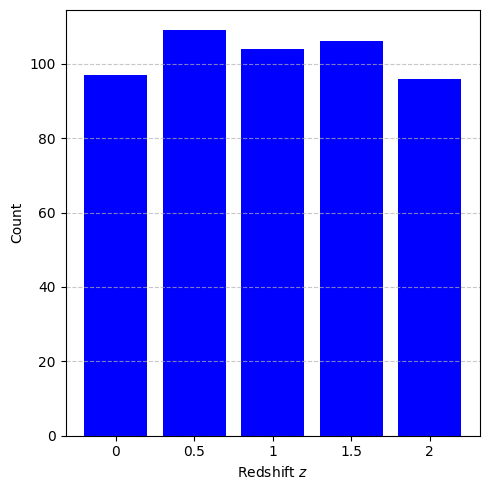

In [ ]:
# Extracting indicies based on their redshift labels,
j_list_z0 =  np.where(redshift_labels == 0)[0]
j_list_z05 = np.where(redshift_labels == 0.5)[0]
j_list_z1 = np.where(redshift_labels == 1)[0]
j_list_z15 = np.where(redshift_labels == 1.5)[0]
j_list_z2 = np.where(redshift_labels == 2)[0]

# Counting redshift values,
redshifts = [0, 0.5, 1, 1.5, 2]
counts = [len(j_list_z0), len(j_list_z05), len(j_list_z1), len(j_list_z15), len(j_list_z2)]
print(counts)

# Plotting,
plt.figure(figsize=(5, 5))
plt.bar([str(z) for z in redshifts], counts, color="blue")
plt.xlabel("Redshift $z$")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

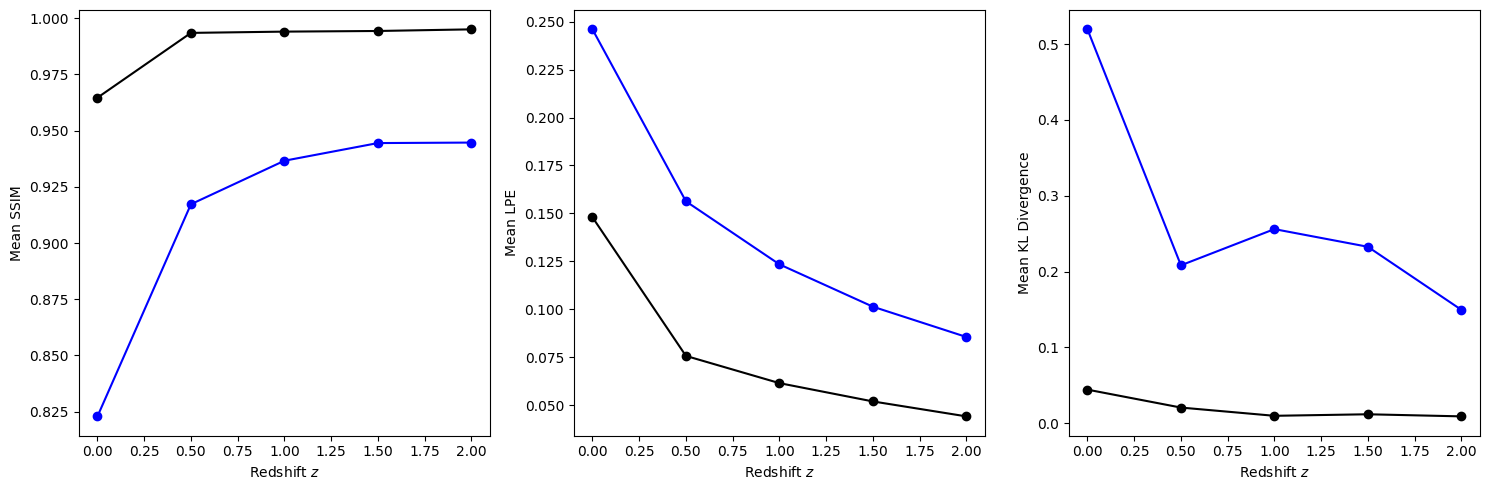

In [ ]:
# PARAMETERS
N_BINS = 50 # <-- For KL divergence

# Creating dictionary for redshifts,
redshift_bins = {
    0.0: j_list_z0,
    0.5: j_list_z05,
    1.0: j_list_z1,
    1.5: j_list_z15,
    2.0: j_list_z2,
}

def plot_metrics_per_redshift():

    # Defining ground truth and prediction for both fields,
    fields = {
        "Ne": (Ne_grid, Ne_pred, "black"),
        "T": (T_grid, T_pred, "blue"),
    }

    # Storing metrics for both fields,
    metrics = {
        "Ne": {"SSIM": [], "LPE": [], "KL": []},
        "T": {"SSIM": [], "LPE": [], "KL": []},
    }

    # Common redshift list
    redshifts = list(redshift_bins.keys())

    for field_name, (field, field_pred, _) in fields.items():

        # Looping through redshift groups,
        for z_val in redshifts:

            indices = redshift_bins[z_val]

            # Creating lists to store metrics for each sample,
            SSIM_list = []
            LPE_list = []
            KL_list = []

            for idx in indices:

                # Extracting ground truth and prediction,
                image = field[idx]
                image_pred = field_pred[idx]
                image_range = image_pred.max() - image_pred.min()

                # Computing SSIM,
                ssim_val = skimage.metrics.structural_similarity(image, image_pred, data_range=image_range)
                SSIM_list.append(ssim_val)

                # Computing LPE,
                lpe_val = compute_LPE(image, image_pred)
                LPE_list.append(lpe_val)

                # Computing KL Divergence,
                hist_gt, _ = np.histogram(np.log10(image).flatten(), bins=N_BINS)
                hist_pred, _ = np.histogram(np.log10(image_pred.flatten()), bins=N_BINS)
                kl_val = compute_KL(hist_gt, hist_pred)
                KL_list.append(kl_val)

            # Appending averaged metrics,
            metrics[field_name]["SSIM"].append(np.mean(SSIM_list))
            metrics[field_name]["LPE"].append(np.mean(LPE_list))
            metrics[field_name]["KL"].append(np.mean(KL_list))

    # Creating figure,
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(redshifts, metrics["Ne"]["SSIM"], marker="o", color="black", label="Electron Number Density")
    plt.plot(redshifts, metrics["T"]["SSIM"], marker="o", color="blue", label="Gas Temperature")
    plt.xlabel("Redshift $z$")
    plt.ylabel("Mean SSIM")

    plt.subplot(1, 3, 2)
    plt.plot(redshifts, metrics["Ne"]["LPE"], marker="o", color="black", label="Electron Number Density")
    plt.plot(redshifts, metrics["T"]["LPE"], marker="o", color="blue", label="Gas Temperature")
    plt.xlabel("Redshift $z$")
    plt.ylabel("Mean LPE")

    plt.subplot(1, 3, 3)
    plt.plot(redshifts, metrics["Ne"]["KL"], marker="o", color="black", label="Electron Number Density")
    plt.plot(redshifts, metrics["T"]["KL"], marker="o", color="blue", label="Gas Temperature")
    plt.xlabel("Redshift $z$")
    plt.ylabel("Mean KL Divergence")

    # Displaying,
    plt.tight_layout()
    plt.show()

# Calling function,
plot_metrics_per_redshift()

# Simulation Predictions

## Load Data

In [ ]:
"""Loading data for the CV-0 Simulation."""

# Mounting drive,
drive.mount("/content/drive", force_remount=True)

# Loading grids,
DMD_grid_z00 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=0.0.npy")
DMD_grid_z05 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=0.5.npy")
DMD_grid_z10 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=1.0.npy")
DMD_grid_z15 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=1.5.npy")
DMD_grid_z20 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=2.0.npy")

Ne_grid_z00 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=0.0.npy")
Ne_grid_z05 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=0.5.npy")
Ne_grid_z10 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=1.0.npy")
Ne_grid_z15 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=1.5.npy")
Ne_grid_z20 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=2.0.npy")

T_grid_z00 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=0.0.npy")
T_grid_z05 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=0.5.npy")
T_grid_z10 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=1.0.npy")
T_grid_z15 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=1.5.npy")
T_grid_z20 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=2.0.npy")

# Loading model predictions,
T_pred_z00 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=0.0-pred.npy")
T_pred_z05 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=0.5-pred.npy")
T_pred_z10 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=1.0-pred.npy")
T_pred_z15 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=1.5-pred.npy")
T_pred_z20 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/T-CV0-z=2.0-pred.npy")

Ne_pred_z00 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=0.0-pred.npy")
Ne_pred_z05 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=0.5-pred.npy")
Ne_pred_z10 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=1.0-pred.npy")
Ne_pred_z15 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=1.5-pred.npy")
Ne_pred_z20 = np.load(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/Ne-CV0-z=2.0-pred.npy")

# Creating dictionaries,
DMD_grids = {"z00": DMD_grid_z00,"z05": DMD_grid_z05,"z10": DMD_grid_z10,"z15": DMD_grid_z15,"z20": DMD_grid_z20}
Ne_grids = {"z00": Ne_grid_z00,"z05": Ne_grid_z05,"z10": Ne_grid_z10,"z15": Ne_grid_z15,"z20": Ne_grid_z20}
Ne_preds = {"z00": Ne_pred_z00,"z05": Ne_pred_z05,"z10": Ne_pred_z10,"z15": Ne_pred_z15,"z20": Ne_pred_z20}
T_grids = {"z00": T_grid_z00,"z05": T_grid_z05,"z10": T_grid_z10,"z15": T_grid_z15, "z20": T_grid_z20}
T_preds = {"z00": T_pred_z00,"z05": T_pred_z05,"z10": T_pred_z10,"z15": T_pred_z15, "z20": T_pred_z20}
z_keys = ["z00", "z05", "z10", "z15", "z20"]
z_suffixes = ["0.0", "0.5", "1.0", "1.5", "2.0"]

Mounted at /content/drive


## Emissivity Field Visualisation

In [ ]:
# PARAMETERS,
PIXEL_SCALE = 25/256 # Mpc/h
MIN_THRESHOLD = 1e-44 # Actual Units
i = 0

def compute_emissivity(n_e, T):
    return (1.42*1e-27)*(n_e**2)*(T**0.5)

def update_emissivity_plot(i):
  """Function called whenever the slider is changed."""

  # Creating figure,
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))

  # Plotting DM grid,
  data = np.log10(DMD_grid_z00[i])
  img_data = axes[0].imshow(data, cmap="inferno")
  axes[0].set_title("DM Density")
  axes[0].set_xlabel("Mpc/$h$")
  axes[0].set_ylabel("Mpc/$h$")
  fig.colorbar(img_data, orientation="horizontal", label = r"$(M_{\odot}/h)/(Mpc/h)^3$ (Logarithmic Scale)")

  # Plotting emissivity grid (ground truth),
  truth = np.log10(emissivity_grid[i])
  img_truth = axes[1].imshow(truth, cmap="inferno")
  axes[1].set_title("Emissivity (Ground Truth)")
  axes[1].set_xlabel("Mpc/$h$")
  axes[1].set_ylabel("Mpc/$h$")
  fig.colorbar(img_truth, orientation="horizontal", label = "ergs $s^{-1}$ c$m^{-3}$ (Logarithmic Scale)")

  # Plotting emissivity grid (prediction),
  pred = np.log10(emissivity_grid_pred[i])
  img_pred = axes[2].imshow(pred, cmap="inferno")
  axes[2].set_title("Emissivity (Model Prediction)")
  axes[2].set_xlabel("Mpc/$h$")
  axes[2].set_ylabel("Mpc/$h$")
  fig.colorbar(img_pred, orientation="horizontal", label = "ergs $s^{-1}$ c$m^{-3}$ (Logarithmic Scale)")

  # Plotting residue,
  ratio = emissivity_grid_pred[i]/emissivity_grid[i]
  img_ratio = axes[3].imshow(ratio, cmap="bwr", norm=colors.LogNorm(vmin=0.01, vmax=100))
  axes[3].set_title("Ratio")
  axes[3].set_xlabel("Mpc/$h$")
  axes[3].set_ylabel("Mpc/$h$")
  fig.colorbar(img_ratio, orientation="horizontal")

  # Updating xticks and yticks,
  for ax in axes:

    xticks = ax.get_xticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]

    # Converting into physical units,
    xtick_labels = [f"{x * PIXEL_SCALE:.0f}" for x in xticks]
    ytick_labels = [f"{y * PIXEL_SCALE:.0f}" for y in yticks]

    # Setting ticks,
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)

  # Displaying plot,
  plt.tight_layout()
  plt.show()

# Computing emissivity,
emissivity_grid = compute_emissivity(n_e=Ne_grid_z00, T=T_grid_z00)
emissivity_grid_pred = compute_emissivity(n_e=Ne_pred_z00, T=T_pred_z00)

# Creating slider,
slider1 = widgets.IntSlider(value=i, min=0, max=100, step=1, description="Slice")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_emissivity_plot, {"i":slider1})

# Display slider and plot,
display(slider1, interactive_plot)

IntSlider(value=0, description='Slice')

Output()

## Cluster Centre Visualisation

In [ ]:
def CCL(field, threshold):
    """Uses a standard two-pass binary connected component labelling (CCL) algorithm to indentify and label clusters on a grid based on a threshold value given."""

    # Create a binary mask of overdense regions,
    binary_mask = field > threshold

    # Label connected regions (FoF-like approach for grid-based data),
    labeled_array, num_features = scipy.ndimage.label(binary_mask)

    # Computing the centres of mass for each cluster,
    cluster_centres = scipy.ndimage.center_of_mass(binary_mask, labeled_array, np.arange(1, num_features + 1))

    # Converting coordinates to integer values,
    cluster_centres_int = []
    for i, cluster_centre in enumerate(cluster_centres):
       cluster_centre_int = (int(cluster_centre[0]), int(cluster_centre[1]), int(cluster_centre[2]))
       cluster_centres_int.append(cluster_centre_int)

    # Converting to NumPy,
    cluster_centres = np.array(cluster_centres)

    return labeled_array, np.array(cluster_centres_int)

# Extracting redshift key,
z = z_keys[0]

# Computing emissivity,
emissivity_grid = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])
emissivity_grid_pred = compute_emissivity(n_e=Ne_preds[z], T=T_preds[z])

"""PARAMETERS"""
THRESHOLD = 1e-32
PIXEL_SCALE = 25/256 # Mpc/h
i = 0 # Inital Slice

# Finding clusters,
labeled_array, cluster_centres = CCL(field=emissivity_grid, threshold=THRESHOLD)
labeled_array_pred, cluster_centres_pred = CCL(field=emissivity_grid_pred, threshold=THRESHOLD)
print(f"Target Cluster Number: {len(cluster_centres)}, Prediction Cluster Number: {len(cluster_centres_pred)}")

def update_cluster_plot(i):
  """Function called whenever the slider is changed."""

  # Creating figure,
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Plotting emissivity grid (ground truth),
  truth = np.log10(emissivity_grid[i])
  img_truth = axes[0].imshow(truth, cmap="inferno")
  axes[0].set_title("Emissivity (Ground Truth)")
  axes[0].set_xlabel("Mpc/$h$")
  axes[0].set_ylabel("Mpc/$h$")
  fig.colorbar(img_truth, orientation="vertical", label = "ergs $s^{-1}$ c$m^{-3}$ (Logarithmic Scale)")

  # Plotting emissivity grid (prediction),
  pred = np.log10(emissivity_grid_pred[i])
  img_pred = axes[1].imshow(pred, cmap="inferno")
  axes[1].set_title("Emissivity (Model Prediction)")
  axes[1].set_xlabel("Mpc/$h$")
  axes[1].set_ylabel("Mpc/$h$")
  fig.colorbar(img_pred, orientation="vertical", label = "ergs $s^{-1}$ c$m^{-3}$ (Logarithmic Scale)")

  # Drawing X marks for the cluster centers at given slice,
  for center in cluster_centres:
      z, y, x = center
      if z == i:
          axes[0].plot(x, y, "x", color="white", markersize=8, markeredgewidth=2)

  for center in cluster_centres_pred:
      z, y, x = center
      if z == i:
          axes[1].plot(x, y, "x", color="white", markersize=8, markeredgewidth=2)

  # Updating xticks and yticks,
  for ax in axes:

    xticks = ax.get_xticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]

    # Converting into physical units,
    xtick_labels = [f"{x * PIXEL_SCALE:.0f}" for x in xticks]
    ytick_labels = [f"{y * PIXEL_SCALE:.0f}" for y in yticks]

    # Setting ticks,
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)

  # Displaying plot,
  plt.tight_layout()
  plt.show()

# Computing emissivity,
emissivity_grid = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])
emissivity_grid_pred = compute_emissivity(n_e=Ne_preds[z], T=T_preds[z])

# Creating slider,
slider1 = widgets.IntSlider(value=i, min=0, max=100, step=1, description="Slice")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_cluster_plot, {"i":slider1})

# Display slider and plot,
display(slider1, interactive_plot)

Target Cluster Number: 339, Prediction Cluster Number: 294


IntSlider(value=0, description='Slice')

Output()

## Cluster Number by Redshift

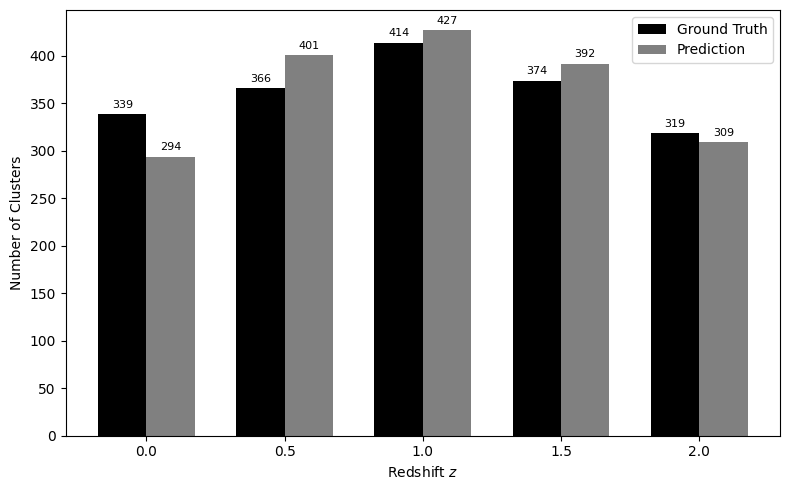

In [ ]:
# Defining lists,
redshift_labels = ["0.0", "0.5", "1.0", "1.5", "2.0"]
N_clusters = []
N_clusters_pred = []

for z in z_keys:

    # Computing total emissivity,
    emissivity_true = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])
    emissivity_pred = compute_emissivity(n_e=Ne_preds[z], T=T_preds[z])

    # Running cluster finding algorithm,
    _, cluster_centres_true = CCL(field=emissivity_true, threshold=THRESHOLD)
    _, cluster_centres_pred = CCL(field=emissivity_pred, threshold=THRESHOLD)

    # Appending to lists,
    N_clusters.append(len(cluster_centres_true))
    N_clusters_pred.append(len(cluster_centres_pred))

# Plotting graoph,
x = np.arange(len(redshift_labels))  # [0, 1, 2, 3, 4]
width = 0.35  # Width of each bar
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, N_clusters, width, label="Ground Truth", color="black")
bars2 = ax.bar(x + width/2, N_clusters_pred, width, label="Prediction", color="grey")

# Add labels and formatting
ax.set_xlabel("Redshift $z$")
ax.set_ylabel("Number of Clusters")
ax.set_xticks(x)
ax.set_xticklabels(redshift_labels)
ax.legend()

# Annotating bar values,
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center", va="bottom", fontsize=8)

# Displaying,
plt.tight_layout()
plt.show()

## Cluster Region Visualisation

In [ ]:
"""PARAMETERS"""
PIXEL_SCALE = 25/256 # Mpc/h
NEIGHBOURHOOD_SIZE = 10 # Pixels
i = NEIGHBOURHOOD_SIZE # Inital Slice Number
j = 45 # Inital Cluster Number

def update_zoomedcluster_plot(i, j):
  """Function called whenever the slider is changed."""

  # Creating figure,
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Extracting zoomed view,
  halo_loc = cluster_centres[j]
  cluster_neighbourhood_emissivity = emissivity_grid[(halo_loc[0] - NEIGHBOURHOOD_SIZE):(halo_loc[0] + NEIGHBOURHOOD_SIZE),
                                                     (halo_loc[1] - NEIGHBOURHOOD_SIZE):(halo_loc[1] + NEIGHBOURHOOD_SIZE),
                                                     (halo_loc[2] - NEIGHBOURHOOD_SIZE):(halo_loc[2] + NEIGHBOURHOOD_SIZE)]

  cluster_neighbourhood_emissivity_pred = emissivity_grid_pred[(halo_loc[0] - NEIGHBOURHOOD_SIZE):(halo_loc[0] + NEIGHBOURHOOD_SIZE),
                                                               (halo_loc[1] - NEIGHBOURHOOD_SIZE):(halo_loc[1] + NEIGHBOURHOOD_SIZE),
                                                               (halo_loc[2] - NEIGHBOURHOOD_SIZE):(halo_loc[2] + NEIGHBOURHOOD_SIZE)]

  # ZOOMED: Target,
  halo_target_img = np.log10(cluster_neighbourhood_emissivity[i])
  img_pred = axes[0].imshow(halo_target_img, cmap="inferno")
  axes[0].set_title("Halo (Target)")
  axes[0].set_xlabel("Mpc/$h$")
  axes[0].set_ylabel("Mpc/$h$")
  fig.colorbar(img_pred , orientation="vertical")

  # ZOOMED: Prediction,
  halo_pred_img = np.log10(cluster_neighbourhood_emissivity_pred[i])
  img_pred = axes[1].imshow(halo_pred_img, cmap="inferno")
  axes[1].set_title("Halo (Prediction)")
  axes[1].set_xlabel("Mpc/$h$")
  axes[1].set_ylabel("Mpc/$h$")
  fig.colorbar(img_pred , orientation="vertical")

  # Updating xticks and yticks,
  for ax in axes:

    xticks = ax.get_xticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]

    # Converting into physical units,
    xtick_labels = [f"{x * PIXEL_SCALE:.0f}" for x in xticks]
    ytick_labels = [f"{y * PIXEL_SCALE:.0f}" for y in yticks]

    # Setting ticks,
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)

  # Displaying plot,
  plt.tight_layout()
  plt.show()

# Computing emissivity,
emissivity_grid = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])
emissivity_grid_pred = compute_emissivity(n_e=Ne_preds[z], T=T_grids[z])

# Creating sliders,
slider1 = widgets.IntSlider(value=i, min=0, max=(2*NEIGHBOURHOOD_SIZE + 1), step=1, description="Slice")
slider2 = widgets.IntSlider(value=j, min=0, max=cluster_centres.shape[0], step=1, description="Cluster Number")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_zoomedcluster_plot, {"i":slider1, "j":slider2})

# Display slider and plot,
clear_output(wait=False)
display(slider1, slider2, interactive_plot)

IntSlider(value=10, description='Slice', max=21)

IntSlider(value=45, description='Cluster Number', max=339)

Output()

## Scaling Relations

In [ ]:
def extract_pixels(field, centre_coord, neighbourhood_size):
    """Helper function to extract the nearby pixels around a cluster location."""
    return field[(centre_coord[0] - neighbourhood_size):(centre_coord[0] + neighbourhood_size),
                 (centre_coord[1] - neighbourhood_size):(centre_coord[1] + neighbourhood_size),
                 (centre_coord[2] - neighbourhood_size):(centre_coord[2] + neighbourhood_size)]

# Parameters,
j = 185
CLUSTER_SIZE = 3
NEIGHBOURHOOD_SIZE = 15

def update_scaling_plot(j):

    # Extracting jth cluster location,
    cluster_loc = cluster_centres[j]

    # Creating figure,
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Extracting pixel values,
    cn_T = extract_pixels(field=T_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
    cn_Ne = extract_pixels(field=Ne_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
    cn_Ne_pred = extract_pixels(field=Ne_preds[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
    cn_T_pred = extract_pixels(field=T_preds[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
    cn_DMD = extract_pixels(field=DMD_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)

    # Flattening and taking the natural log,
    cluster_DMD_vals = np.log10(cn_DMD.flatten())
    cluster_Ne_vals = np.log10(cn_Ne.flatten())
    cluster_Ne_predvals = np.log10(cn_Ne_pred.flatten())
    cluster_T_vals = np.log10(cn_T.flatten())
    cluster_T_predvals = np.log10(cn_T_pred.flatten())

    # Computing lines of best fit,
    m, b = np.polyfit(cluster_DMD_vals, cluster_Ne_vals, deg=1)
    m_pred, b_pred = np.polyfit(cluster_DMD_vals, cluster_Ne_predvals, deg=1)

    # Plotting main graphs,
    axes[0].scatter(cluster_DMD_vals, cluster_Ne_vals, color = "black", label = "CAMELS-IllustrisTNG", alpha=0.5)
    axes[0].scatter(cluster_DMD_vals, cluster_Ne_predvals, color = "blue", label = "CosmoMap", alpha=0.5)
    axes[0].plot(cluster_DMD_vals, cluster_DMD_vals*m + b, color = "black")
    axes[0].plot(cluster_DMD_vals, cluster_DMD_vals*m_pred + b_pred, color = "blue")
    axes[0].set_xlabel("""Dark Matter Density $Log_{10}(\\rho_{DM}/M)$""")
    axes[0].set_ylabel("Electron Number Density $Log_{10}(n_e/h^2 cm^2)$")
    axes[0].set_title("Gas–Dark Matter Density Relation")
    axes[0].legend(loc="upper left")

    axes[1].scatter(cluster_DMD_vals, cluster_T_vals, color = "black", label = "CAMELS-IllustrisTNG", alpha=0.8)
    axes[1].scatter(cluster_DMD_vals, cluster_T_predvals, color = "blue", label = "CosmoMap", alpha=0.8)
    sns.kdeplot(x=cluster_DMD_vals, y=cluster_T_vals, ax=axes[1], levels=5, color="black", label="CAMELS KDE", fill=True, alpha=0.35)
    sns.kdeplot(x=cluster_DMD_vals, y=cluster_T_predvals, ax=axes[1], levels=5, color="blue", label="CosmoMap KDE", fill=True, alpha=0.35)
    axes[1].set_xlabel("""Dark Matter Density $Log_{10}(\\rho_{DM}/M)$""")
    axes[1].set_ylabel("Temperature $Log_{10}(T/K)$")
    axes[1].set_title("Gas Temperature–Dark Matter Density Relation")
    axes[1].legend(loc="upper left")

    # Plotting visualisation images,
    ax_main = axes[2]
    ax_main.set_title("Visualisation")
    ax_main.axis("off")

    # Creating positions for images,
    positions = [(0.05, 0.55), (0.55, 0.55), (0.05, 0.05), (0.55, 0.05)]
    titles = ["Temperature (Ground Truth)", "Temperature (Prediction)", "Electron Number Density (Ground Truth)", "Electron Number Density (Prediction)"]

    # Extracting pixel values,
    cn_T = extract_pixels(field=T_grids[z], centre_coord=cluster_loc, neighbourhood_size=NEIGHBOURHOOD_SIZE)
    cn_Ne = extract_pixels(field=Ne_grids[z], centre_coord=cluster_loc, neighbourhood_size=NEIGHBOURHOOD_SIZE)
    cn_Ne_pred = extract_pixels(field=Ne_preds[z], centre_coord=cluster_loc, neighbourhood_size=NEIGHBOURHOOD_SIZE)
    cn_T_pred = extract_pixels(field=T_preds[z], centre_coord=cluster_loc, neighbourhood_size=NEIGHBOURHOOD_SIZE)
    cn_DMD = extract_pixels(field=DMD_grids[z], centre_coord=cluster_loc, neighbourhood_size=NEIGHBOURHOOD_SIZE)
    grids = [cn_T, cn_T_pred, cn_Ne, cn_Ne_pred]

    # Rendering images,
    for grid_idx, (x, y) in enumerate(positions):
        ax_inset = inset_axes(ax_main, width="40%", height="40%", loc="lower left",
                              bbox_to_anchor=(x, y, 1, 1), bbox_transform=ax_main.transAxes, borderpad=0)

        img = np.log10(grids[grid_idx][NEIGHBOURHOOD_SIZE])
        img_obj = ax_inset.imshow(img, origin="lower")
        ax_inset.set_title(titles[grid_idx], fontsize=8)
        ax_inset.axis("off")

    # Display plot,
    plt.show()

# Creating sliders,
slider = widgets.IntSlider(value=j, min=0, max=cluster_centres.shape[0], step=1, description="Cluster Number")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_scaling_plot, {"j":slider})
clear_output(wait=False)
display(slider, interactive_plot)

IntSlider(value=185, description='Cluster Number', max=339)

Output()

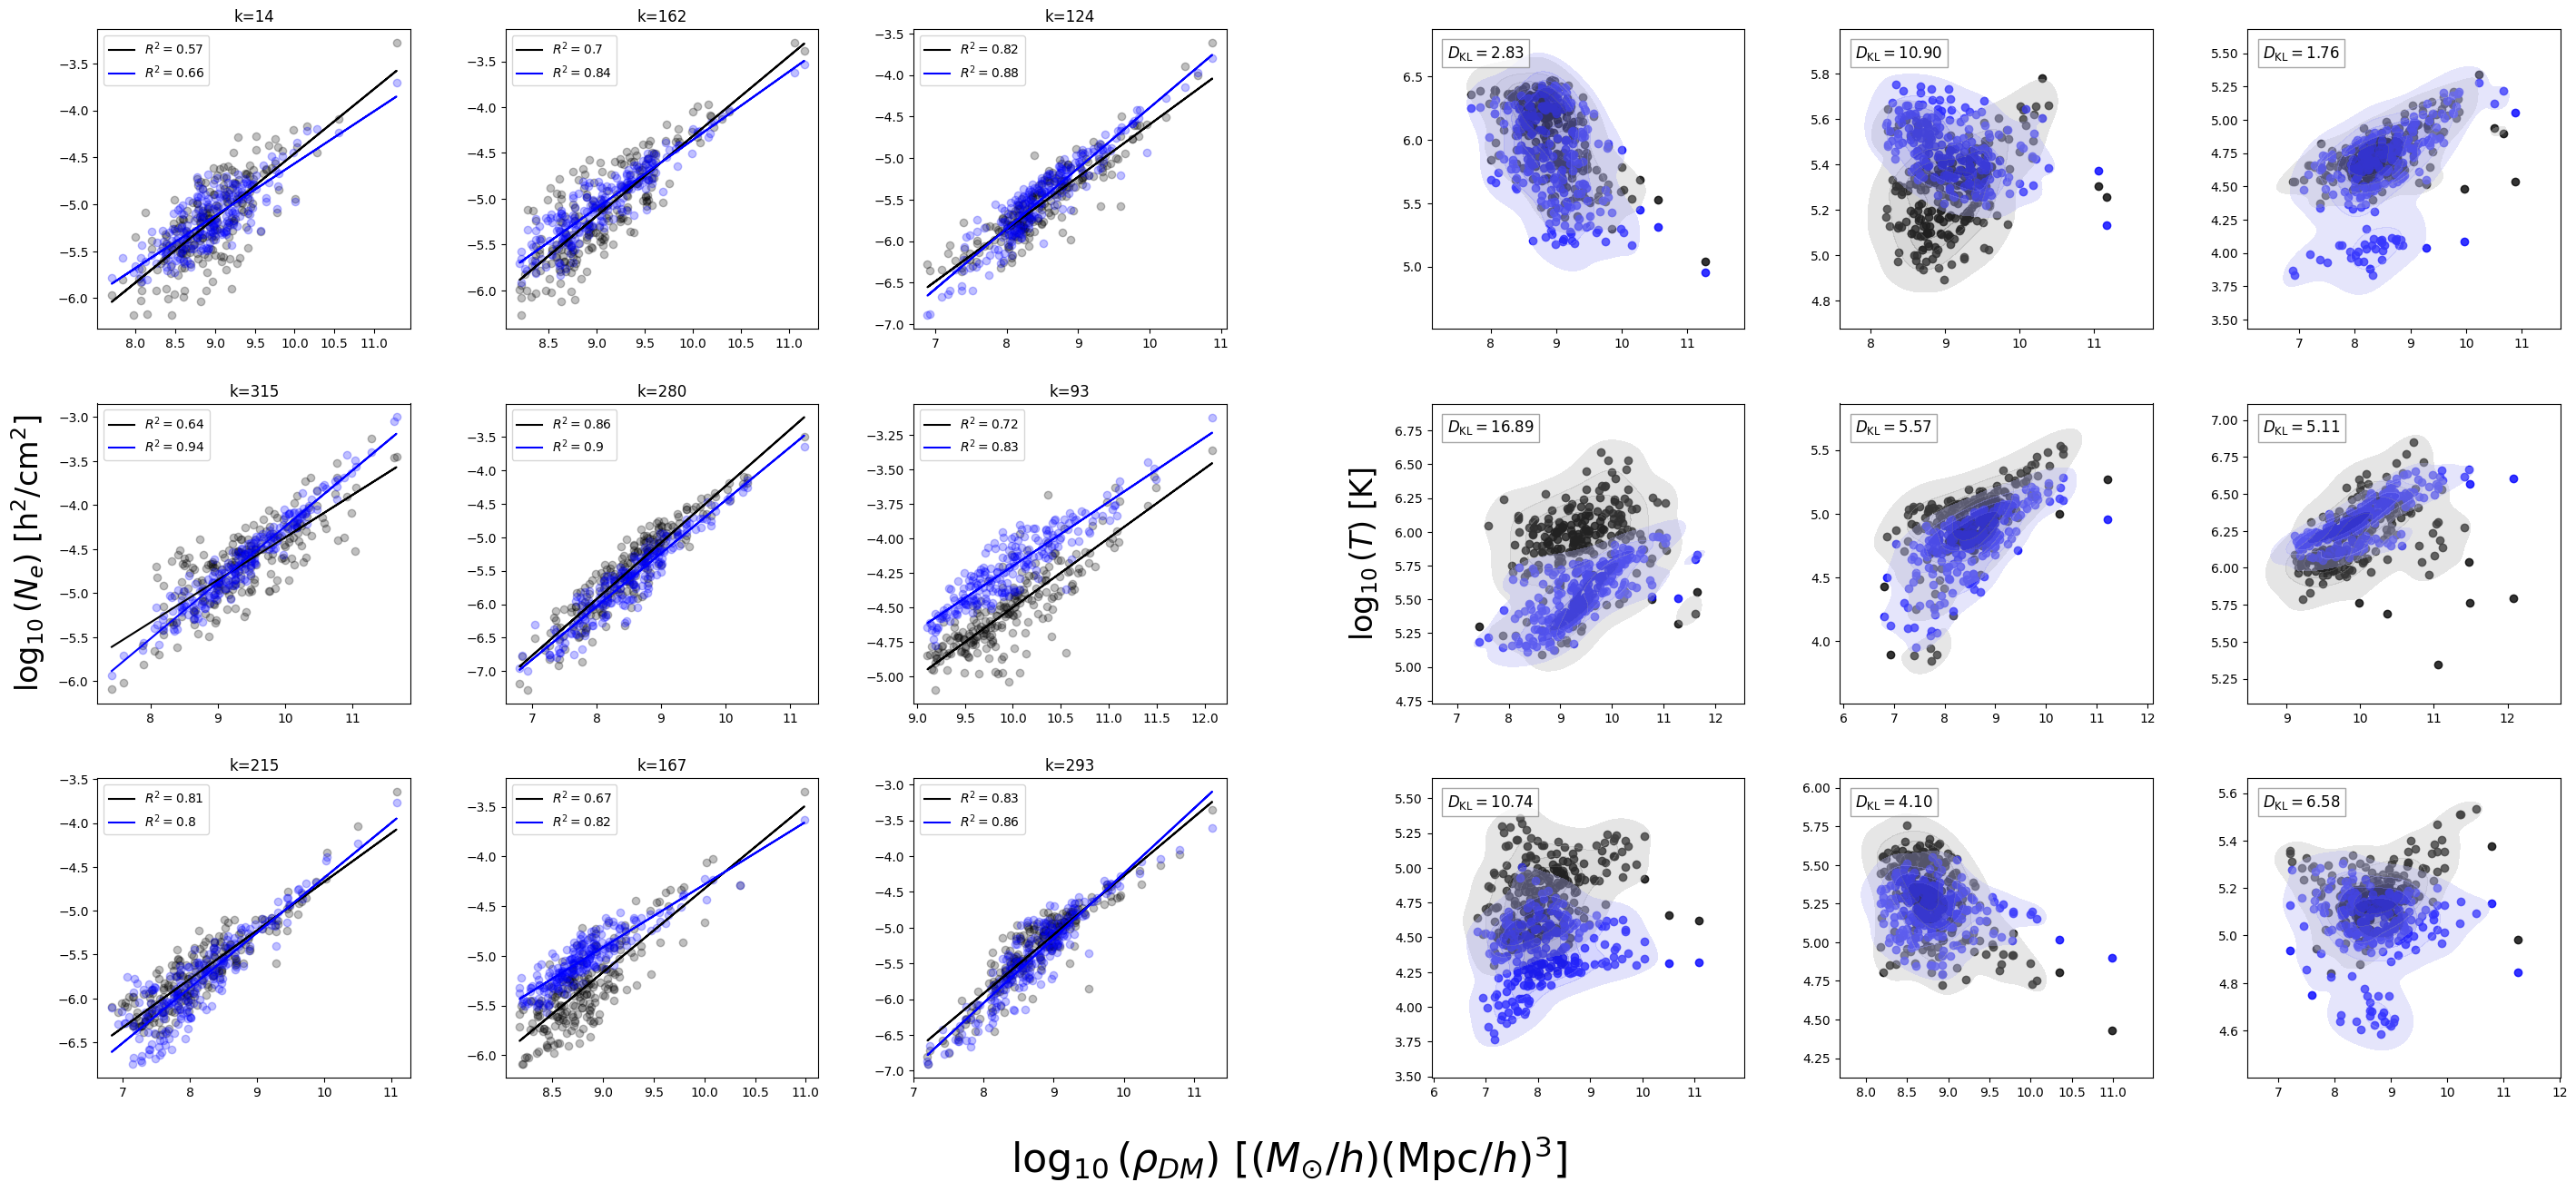

In [ ]:
def compute_KL_joint(hist_gt, hist_pred, epsilon=1e-10):
    """Safely computes KL divergence between two 2D histograms representing joint distributions."""

    # Ensure input is converted to float and add epsilon to avoid log(0) and div by zero
    hist_gt = np.asarray(hist_gt, dtype=np.float64) + epsilon
    hist_pred = np.asarray(hist_pred, dtype=np.float64) + epsilon

    # Normalize to get valid joint probability distributions
    hist_gt /= np.sum(hist_gt)
    hist_pred /= np.sum(hist_pred)

    # Flatten the 2D histograms to 1D arrays for KL divergence computation
    return scipy.stats.entropy(hist_gt.ravel(), hist_pred.ravel())

# Toggle to specifiy j_list,
k_list = [14, 162, 124, 315, 280, 93, 215, 167, 293]
N_BINS = 10

def plot_scalings():

    # Creating figure,
    fig = plt.figure(figsize=(35, 15))
    gs = plt.GridSpec(3, 7, figure=fig, wspace=0.35, hspace=0.25, width_ratios=[1, 1, 1, 0.05, 1, 1, 1])
    axes = np.empty((3, 6), dtype=object)

    for row in range(3):
        for col in range(3):
            axes[row, col] = fig.add_subplot(gs[row, col])
            axes[row, col + 3] = fig.add_subplot(gs[row, col + 4])

    # Plotting loop,
    for idx, k in enumerate(k_list):
        row = idx // 3
        col = idx % 3

        # Extracting jth cluster location,
        cluster_loc = cluster_centres[k]

        # Extracting pixel values,
        cn_T = extract_pixels(field=T_grid_z00, centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
        cn_Ne = extract_pixels(field=Ne_grid_z00, centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
        cn_Ne_pred = extract_pixels(field=Ne_pred_z00, centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
        cn_T_pred = extract_pixels(field=T_pred_z00, centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
        cn_DMD = extract_pixels(field=DMD_grid_z00, centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)

        # Flattening and taking the natural log,
        cluster_DMD_vals = np.log10(cn_DMD.flatten())
        cluster_Ne_vals = np.log10(cn_Ne.flatten())
        cluster_Ne_predvals = np.log10(cn_Ne_pred.flatten())
        cluster_T_vals = np.log10(cn_T.flatten())
        cluster_T_predvals = np.log10(cn_T_pred.flatten())

        # Computing lines of best fit,
        m, b = np.polyfit(cluster_DMD_vals, cluster_Ne_vals, deg=1)
        m_pred, b_pred = np.polyfit(cluster_DMD_vals, cluster_Ne_predvals, deg=1)

        # Computing R² for lines of best fit,
        y_pred = m * cluster_DMD_vals + b
        r2 = r2_score(cluster_Ne_vals, y_pred)
        y_pred_model = m_pred * cluster_DMD_vals + b_pred
        r2_pred = r2_score(cluster_Ne_predvals, y_pred_model)

        # Computing joint KL divergence,
        xmin, xmax = np.min(cluster_DMD_vals), np.max(cluster_DMD_vals)
        ymin, ymax = np.min(cluster_T_vals), np.max(cluster_T_vals)
        hist_gt, xedges, yedges = np.histogram2d(cluster_DMD_vals, cluster_T_vals, bins=N_BINS, range=[[xmin, xmax], [ymin, ymax]], density=False)
        hist_pred, _, _ = np.histogram2d(cluster_DMD_vals, cluster_T_predvals, bins=[xedges, yedges], density=False)
        KL_div = compute_KL_joint(hist_gt=hist_gt, hist_pred=hist_pred)

        """LEFT COLUMN: DMD-Ne relation"""
        ax_dmd_Ne = axes[row, col]
        ax_dmd_Ne.scatter(cluster_DMD_vals, cluster_Ne_vals, color = "black", alpha=0.25)
        ax_dmd_Ne.scatter(cluster_DMD_vals, cluster_Ne_predvals, color = "blue", alpha=0.25)
        ax_dmd_Ne.plot(cluster_DMD_vals, cluster_DMD_vals*m + b, color = "black", label=f"$R^2={round(r2, 2)}$")
        ax_dmd_Ne.plot(cluster_DMD_vals, cluster_DMD_vals*m_pred + b_pred, color = "blue", label=f"$R^2={round(r2_pred, 2)}$")
        ax_dmd_Ne.set_title(f"k={k}")
        ax_dmd_Ne.legend(loc="upper left")

        """RIGHT COLUMN: DMD-T relation"""
        ax_dmd_T = axes[row, col + 3]
        ax_dmd_T.scatter(cluster_DMD_vals, cluster_T_vals, color = "black", label = "CAMELS-IllustrisTNG", alpha=0.8)
        ax_dmd_T.scatter(cluster_DMD_vals, cluster_T_predvals, color = "blue", label = "CosmoMap", alpha=0.8)
        sns.kdeplot(x=cluster_DMD_vals, y=cluster_T_vals, ax=ax_dmd_T, levels=5, color="black", label="CAMELS KDE", fill=True, alpha=0.35)
        sns.kdeplot(x=cluster_DMD_vals, y=cluster_T_predvals, ax=ax_dmd_T, levels=5, color="blue", label="CosmoMap KDE", fill=True, alpha=0.35)
        ax_dmd_T.text(0.05, 0.95, fr"$D_{{\mathrm{{KL}}}} = {KL_div:.2f}$", transform=ax_dmd_T.transAxes,
              fontsize=12, verticalalignment="top", horizontalalignment="left",
              bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"))

    # Adding shared y-axis labels using invisible axes,
    ax_group1 = fig.add_subplot(gs[:, 0:3], frameon=False)
    ax_group2 = fig.add_subplot(gs[:, 4:7], frameon=False)

    # Looping through axes,
    for ax in [ax_group1, ax_group2]:
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax.set_xticks([])
        ax.set_yticks([])

    ax_group1.set_ylabel(r"$\log_{10}(N_e) \ [\text{h}^2/\text{cm}^2]$", labelpad=40, fontsize=24)
    ax_group2.set_ylabel(r"$\log_{10}(T) \ [\text{K}]$", labelpad=40, fontsize=24)
    fig.text(0.5, 0.04, r"$ \log_{10}(\rho_{DM}) \ [(M_{\odot}/h)(\text{Mpc}/h)^3] $", ha='center', fontsize=32)

    # Displaying plot,
    plt.show()

# Plotting,
plot_scalings()

## Electron Density Scaling Parameter

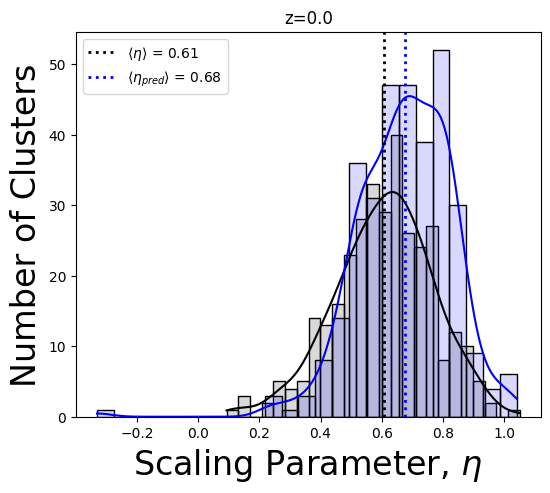

In [ ]:
# Extracting redshift key,
redshift_index = 0
redshift_labels = ["0.0", "0.5", "1.0", "1.5", "2.0"]
z = z_keys[redshift_index]
z_label = redshift_labels[redshift_index]

# Computing total emissivity,
emissivity_field = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])

# Running cluster finding algorithm,
_, cluster_centres = CCL(field=emissivity_field, threshold=THRESHOLD)

# Defining empty lists,
scaling_param_Ne = []
scaling_param_Ne_pred = []

# Plotting loop,
for i, cluster_loc in enumerate(cluster_centres):

  # Extracting pixel values,
  cn_Ne = extract_pixels(field=Ne_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
  cn_Ne_pred = extract_pixels(field=Ne_preds[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
  cn_DMD = extract_pixels(field=DMD_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)

  # Flattening and taking the natural log,
  cluster_DMD_vals = np.log10(cn_DMD.flatten())
  cluster_Ne_vals = np.log10(cn_Ne.flatten())
  cluster_Ne_predvals = np.log10(cn_Ne_pred.flatten())

  try:
    # Computing lines of best fit,
    m, b = np.polyfit(cluster_DMD_vals, cluster_Ne_vals, deg=1)
    m_pred, b_pred = np.polyfit(cluster_DMD_vals, cluster_Ne_predvals, deg=1)

    # Appending,
    scaling_param_Ne.append(m)
    scaling_param_Ne_pred.append(m_pred)

  except:
    pass

# Converting to NumPy array,
scaling_param_Ne = np.array(scaling_param_Ne)
scaling_param_Ne_pred = np.array(scaling_param_Ne_pred)

"""PLOTTING"""
# Creating figure,
figure, axis = plt.subplots(1, figsize=(6, 5))

# Plotting,
N_BINS = 25
hist_1 = sns.histplot(scaling_param_Ne, bins=N_BINS, axes=axis, kde=True, color="black", alpha=0.15)
hist_2 = sns.histplot(scaling_param_Ne_pred, bins=N_BINS, axes=axis, kde=True, color="blue", alpha=0.15)
eta_mean, eta_mean_pred = np.mean(scaling_param_Ne), np.mean(scaling_param_Ne_pred)
plt.title(f"z={z_label}")
plt.axvline(x=eta_mean, color="black", linestyle=":", linewidth=2, label=fr"$\langle \eta \rangle$ = {eta_mean:.2f}")
plt.axvline(x=eta_mean_pred, color="blue", linestyle=":", linewidth=2, label=fr"$\langle \eta_{{pred}} \rangle$ = {eta_mean_pred:.2f}")
plt.legend(loc="upper left")
axis.set_xlabel(r"Scaling Parameter, $\eta$", fontsize=24)
axis.set_ylabel(r"Number of Clusters", fontsize=24)
plt.show()

## DMD-Temperature Mapping Analysis

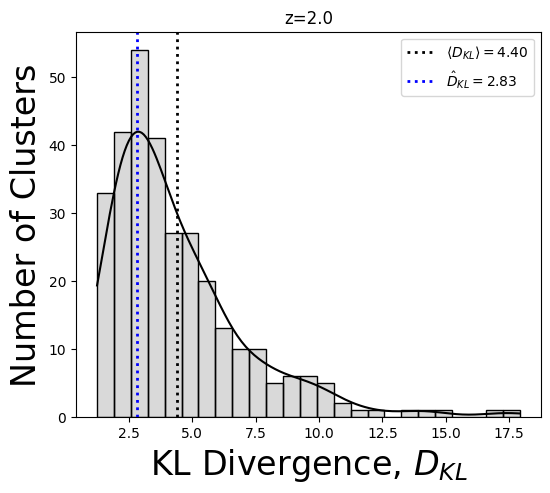

In [ ]:
def compute_peak(axis_obj):
  """Finds the location of the highest point of the KDE after it has been created by Seaborn."""

  # Accessing values,
  for line in axis_obj.lines:
    x_vals = line.get_xdata()
    y_vals = line.get_ydata()
    break

  # Finding KDE peak,
  peak_x = x_vals[np.argmax(y_vals)]

  return peak_x

# Parameters,
KL_BINS = 10
N_BINS = 25

# Extracting redshift key,
redshift_index = 4
redshift_labels = ["0.0", "0.5", "1.0", "1.5", "2.0"]
z = z_keys[redshift_index]
z_label = redshift_labels[redshift_index]

# Computing total emissivity,
emissivity_field = compute_emissivity(n_e=Ne_grids[z], T=T_grids[z])

# Running cluster finding algorithm,
_, cluster_centres = CCL(field=emissivity_field, threshold=THRESHOLD)

# Defining empty lists,
KL_divs = []

# Plotting loop,
for i, cluster_loc in enumerate(cluster_centres):

  # Extracting pixel values,
  cn_T = extract_pixels(field=T_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
  cn_T_pred = extract_pixels(field=T_preds[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)
  cn_DMD = extract_pixels(field=T_grids[z], centre_coord=cluster_loc, neighbourhood_size=CLUSTER_SIZE)

  # Flattening and taking the natural log,
  cluster_DMD_vals = np.log10(cn_DMD.flatten())
  cluster_T_vals = np.log10(cn_T.flatten())
  cluster_T_predvals = np.log10(cn_T_pred.flatten())

  try:
    # Computing joint KL divergence,
    xmin, xmax = np.min(cluster_DMD_vals), np.max(cluster_DMD_vals)
    ymin, ymax = np.min(cluster_T_vals), np.max(cluster_T_vals)
    hist_gt, xedges, yedges = np.histogram2d(cluster_DMD_vals, cluster_T_vals, bins=KL_BINS, range=[[xmin, xmax], [ymin, ymax]], density=False)
    hist_pred, _, _ = np.histogram2d(cluster_DMD_vals, cluster_T_predvals, bins=[xedges, yedges], density=False)
    KL_div = compute_KL_joint(hist_gt=hist_gt, hist_pred=hist_pred)

    # Appending,
    KL_divs.append(KL_div)
  except:
    pass

# Converting to NumPy array,
KL_divs = np.array(KL_divs)

"""PLOTTING"""

# Creating figure,
figure, axis = plt.subplots(1, figsize=(6, 5))

# Plotting,
hist = sns.histplot(KL_divs, bins=N_BINS, axes=axis, kde=True, color="black", alpha=0.15)
KL_div_mean, KL_div_mode = np.mean(KL_divs), compute_peak(axis_obj=hist)
plt.axvline(x=KL_div_mean, color="black", linestyle=":", linewidth=2, label=fr"$\langle D_{{KL}} \rangle = {KL_div_mean:.2f}$")
plt.axvline(x=KL_div_mode, color="blue", linestyle=":", linewidth=2, label=fr"$\hat{{D}}_{{KL}} = {KL_div_mode:.2f}$")
plt.title(f"z={z_label}")
plt.legend(loc="upper right")
axis.set_xlabel(r"KL Divergence, $D_{KL}$", fontsize=24)
axis.set_ylabel(r"Number of Clusters", fontsize=24)
plt.show()

## The Cluster Correlation Function

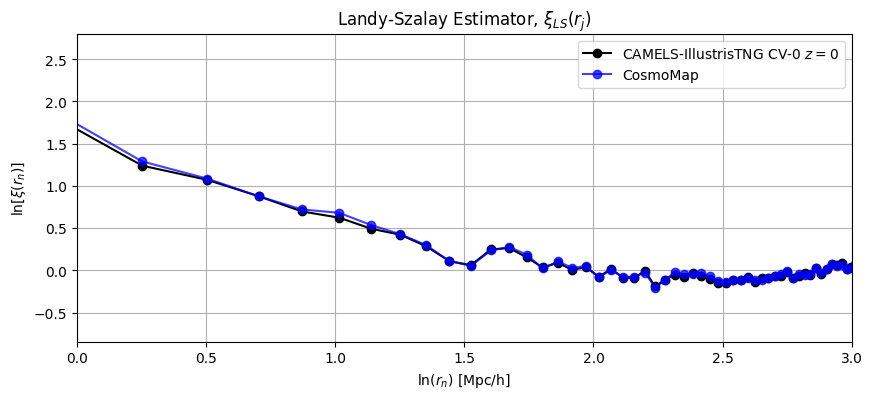

In [ ]:
def compute_LSE(clusters, bins, size_factor, length_scale, max_distance):
    """Helper function to compute the Landy-Szalay estimator (LSE) for the cluster correlation function
    (CCF)."""

    # Creating random distribution,
    random_cluster_centres = []
    for i in range(size_factor*cluster_centres.shape[0]):
        random_cluster_centre = np.random.randint(low=0, high=256, size=3)
        random_cluster_centres.append(random_cluster_centre)
    random_cluster_centres = np.array(random_cluster_centres)

    # Compute all pairwise distances,
    DD_pairwise_distances = sklearn.metrics.pairwise_distances(cluster_centres).flatten()
    RR_pairwise_distances = sklearn.metrics.pairwise_distances(random_cluster_centres).flatten()
    DR_pairwise_distances = sklearn.metrics.pairwise_distances(cluster_centres, random_cluster_centres).flatten()

    # Create the width of the bins,
    bin_edges = np.linspace(start=DD_pairwise_distances.min(), stop=DD_pairwise_distances.max(), num=(bins+1))
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])*PIXEL_SCALE

    # Computing histograms,
    DD, _ = np.histogram(DD_pairwise_distances, bins=bin_edges)
    RR, _ = np.histogram(RR_pairwise_distances, bins=bin_edges)
    DR, _ = np.histogram(DR_pairwise_distances, bins=bin_edges)

    # Normalising histrograms,
    n_data, n_random = cluster_centres.shape[0], random_cluster_centres.shape[0]
    A_DD = 2/(n_data*(n_data - 1))
    A_RR = 2/(n_random*(n_random-1))
    A_DR = 1/(n_data*n_random)

    # Computing Landy-Szalay estimator,
    epsilon_LS = (DD/RR)*(A_DD/A_RR) - 2*(DR/RR)*(A_DR/A_RR) + 1

    return epsilon_LS, bin_centers

# Parameters,
N_BINS = 100
SIZE_FACTOR = 10
PIXEL_SCALE = 25/256 # Mpc/h
MAX_SEP = 30 # Mpc/h

# Computing total emissivity,
z="z0.0"
emissivity_grid = compute_emissivity(n_e=Ne_grid_z00, T=T_grid_z00)
emissivity_pred = compute_emissivity(n_e=Ne_pred_z00, T=T_pred_z00)

# Running cluster finding algorithm,
_, cluster_centres = CCL(field=emissivity_grid, threshold=THRESHOLD)
_, cluster_centres_pred = CCL(field=emissivity_pred, threshold=THRESHOLD)

# Computing Landy-Szalay estimators,
epsilon_LS, bin_centers = compute_LSE(clusters=cluster_centres, bins=N_BINS, size_factor=SIZE_FACTOR, length_scale=PIXEL_SCALE, max_distance=MAX_SEP)
epsilon_LS_pred, _ = compute_LSE(clusters=cluster_centres_pred, bins=N_BINS, size_factor=SIZE_FACTOR, length_scale=PIXEL_SCALE, max_distance=MAX_SEP)

# Plotting,
plt.figure(figsize=(10, 4))
plt.plot(np.log(bin_centers), np.log(epsilon_LS), marker="o", color="black", label="CAMELS-IllustrisTNG CV-0 $z=0$")
plt.plot(np.log(bin_centers), np.log(epsilon_LS_pred), marker="o", color="blue", label="CosmoMap", alpha=0.75)
plt.xlim(0, 3)
plt.xlabel("ln($r_n$) [Mpc/h]")
plt.ylabel("ln[$ξ(r_n)$]")
plt.title("Landy-Szalay Estimator, $\\xi_{LS}(r_j)$")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()